## Integrantes Gropu 5
## Ponce Miguel
## Castro Luis
## Virgilio
## Sanchez Raul


In [0]:
# Cargar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import (active_contour, felzenszwalb, quickshift, 
                                 mark_boundaries, slic, clear_border)

from skimage.future.graph import rag_mean_color, cut_normalized
import io

from itertools import product
import skimage.filters as skfilt
from sklearn.cluster import KMeans
from PIL import Image
from skimage.color import rgb2gray, label2rgb, rgb2hsv
from skimage import morphology
from skimage.morphology import square,disk
from scipy import ndimage as ndi
from skimage.exposure import rescale_intensity
from skimage import exposure
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.segmentation import clear_border

In [0]:
# Defino una función para mostrar una imagen por pantalla con el criterio que considero más acertado
def imshow(img):
    fig, ax = plt.subplots(figsize=(7, 7))
    # El comando que realmente muestra la imagen
    ax.imshow(img,cmap=plt.cm.gray)
    # Para evitar que aparezcan los números en los ejes
    ax.set_xticks([]), ax.set_yticks([])
    plt.show()

In [0]:
# Función para comparar cómo de buena es una determinada segmentación en comparación con el ground truth
# Ambas imagenes deben contener valores True/False
def factor_f_evaluation(binary_image, ground_truth):
    TP = np.sum(np.logical_and(binary_image, ground_truth))
    TN = np.sum(np.logical_and(np.logical_not(binary_image), np.logical_not(ground_truth)))
    FP = np.sum(np.logical_and(np.logical_not(binary_image), ground_truth))
    FN = np.sum(np.logical_and(binary_image, np.logical_not(ground_truth)))
    P = TP/np.float(TP+FP)
    R = TP/np.float(TP+FN)
    if P+R == 0:
        F = 0
    else:
        F = 2*P*R/(P+R)
    return F

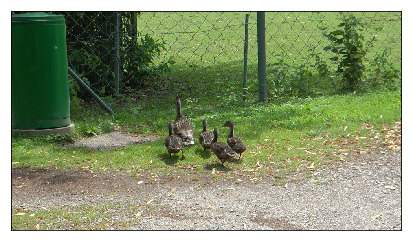

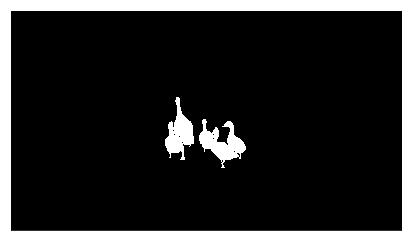

In [60]:
# https://lmb.informatik.uni-freiburg.de/resources/datasets/moseg.en.html
patos = Image.open('ducks01_0100.jpg')
gt_patos = rgb2gray(data.imread('ducks01_0100_gt.ppm'))<1
imshow(patos)
imshow(gt_patos)

### Función para delimitar el espacio en el que se encuentran los patos, creando una copia de mapa de pixeles, tomando solo los pixeles en los que se encuentras los patos y el resto de pixeles cambiarles el color por uno neutro a la de la imagen original


In [0]:
def segmentacion_por_color_patos(foto):
  pixelMap = foto.load()
  img = Image.new(foto.mode, foto.size)
  pixelsNew = img.load()
  verde_bajos = (200, 200, 200)
  verde_altos = (255, 255, 255)

  for i in range(img.size[0]):
      for j in range(img.size[1]):
          if (j<210) :
              pixelsNew[i,j] = (64,85,42)
          elif (j>390):
              pixelsNew[i,j] = (64,85,42)
          elif (j>200)&(i<370):
              pixelsNew[i,j] = (64,85,42)
          elif (j>200)&(i>580):
              pixelsNew[i,j] = (64,85,42)
          elif (j<260)&(i>430):
              pixelsNew[i,j] = (64,85,42)  
          elif (j<270)&(i<400):
              pixelsNew[i,j] = (64,85,42)
          elif (j>370)&(i<500):
              pixelsNew[i,j] = (64,85,42) 
          elif (j>370)&(i>540):
              pixelsNew[i,j] = (64,85,42) 
          elif (j<310)&(i>550):
              pixelsNew[i,j] = (64,85,42) 
          elif verde_bajos<pixelMap[i,j]<verde_altos:
              pixelsNew[i,j] = (40,25,17) 
          else:
              pixelsNew[i,j] = pixelMap[i,j]
              
  return img

### Segmentación de imágenes con k-means
La segmentación divide una imagen en regiones con propiedades internas coherentes. En este algoritmo agrupamos los píxeles para separar los elementos significativos de una imagen y así poder extraer cierta información de alguno de ellos

In [0]:
def segmentacion_k_means(img):
  hsv_img = rgb2hsv(img)
  hue_img = hsv_img[:, :, 0]
  I1 = hue_img
  I2 = np.asarray(I1,dtype=np.float)
  X = I2.reshape((-1, 1))
  k_means = KMeans(n_clusters=2)
  k_means.fit(X)
  centroides = k_means.cluster_centers_
  etiquetas = k_means.labels_
  I2_compressed = np.choose(etiquetas, centroides)
  I2_compressed.shape = I2.shape
  I_T = I2_compressed.copy()
  I_T[I_T >= 0.74] = 0
  I_T[I_T < 0.1] = 0
  I_T.shape
  thresh =  skfilt.threshold_otsu(I_T)
  binary = I_T > thresh
  binary_neg = ~binary
  return binary_neg

In [0]:
def tratamiento_hue(hsv_img):
    hue_img = hsv_img[:, :, 0]
    duck_det = ndi.median_filter(hue_img,3)
    thresh_min = skfilt.threshold_otsu(duck_det)
    binary_du_min = ~(duck_det > thresh_min)
    binary_du_min = morphology.remove_small_objects(binary_du_min,600)
    binary_du_min=morphology.erosion(image=binary_du_min,selem=disk(2))
    return binary_du_min

In [0]:
def tratamiento_value(hsv_img):
    value_img = hsv_img[:, :, 2]
    med_denoised = ndi.median_filter(value_img, 3)
    img_tmp=rescale_intensity(med_denoised, in_range=(0.22, .7), out_range=(0, 1))
    gamma_corrected = exposure.adjust_gamma(img_tmp, 0.1)
    thresh_min = skfilt.threshold_otsu(gamma_corrected)
    binary_du_min = gamma_corrected < thresh_min
    return binary_du_min

In [0]:
def tratamiento_reescala(hsv_img):
    hue_img = hsv_img[:, :, 0]
    med_denoised_hue = ndi.median_filter(hue_img, 4)
    img_tmp_hue=rescale_intensity(med_denoised_hue, in_range=(0.01, .3), out_range=(0, 1))
    gamma_corrected_hue = exposure.adjust_gamma(img_tmp_hue, 0.08)
    thresh_val = skfilt.threshold_otsu(gamma_corrected_hue)
    new_mask = gamma_corrected_hue < thresh_val
    return new_mask

In [0]:
def tratamiento_bordes(imagen):   
    thresh = threshold_otsu(imagen)
    borde_image = closing(imagen > thresh, square(4))  
    return clear_border(borde_image)

### Morfología de una imagen
La morfología es un amplio conjunto de operaciones de procesamiento de imágenes que procesan imágenes basadas en formas. En una operación morfológica, cada píxel de la imagen se ajusta en función del valor de otros píxeles en su vecindad. Al elegir el tamaño y la forma del vecindario, puede construir una operación morfológica que sea sensible a formas específicas en la imagen de entrada

In [0]:
def tratamiento_morfologia(binary_min):
  im0=morphology.remove_small_objects(binary_min,70)
  im1=morphology.dilation(image=im0,selem=disk(1))
  im2=morphology.erosion(image=im1,selem=disk(1))
  im3 = ndi.binary_fill_holes(im2)
  im4 = morphology.dilation(image=im3,selem=disk(1))
  return im4

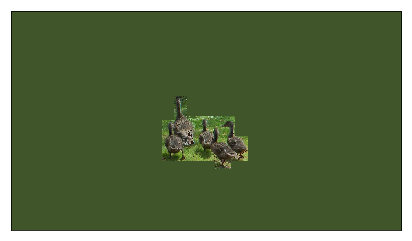

In [68]:
patos_color = segmentacion_por_color_patos(patos)
imshow(patos_color)

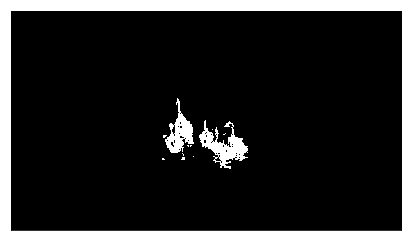

In [69]:
patos_k_means=segmentacion_k_means(patos_color)
imshow(patos_k_means)

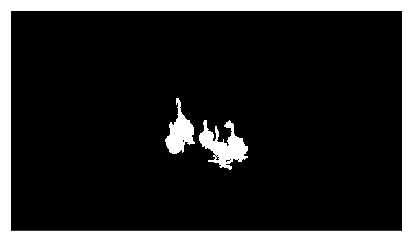

In [84]:
patos_k_means_morphology = tratamiento_morfologia(patos_k_means)
imshow(patos_k_means_morphology)

# Evaluación de resultados en procentaje por segmentación de imágenes con k-means


In [85]:
factor_f_evaluation(patos_k_means_morphology,gt_patos) * 100

88.27769673045567

### Tratamiento de imagen por histograma(reescala de intensidad)


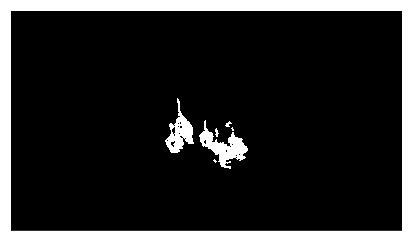

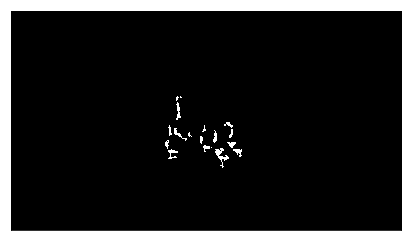

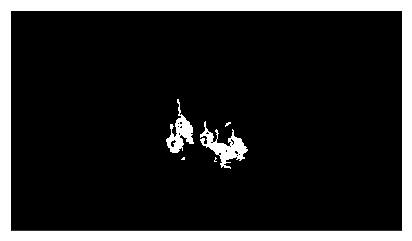

In [89]:
hsv_img = rgb2hsv(patos_color)
hue_img = tratamiento_hue(hsv_img)
value_img=tratamiento_value(hsv_img)
reescal_img=tratamiento_reescala(hsv_img)
im1=morphology.dilation(image=hue_img,selem=disk(2))
imshow(im1)
im2=morphology.remove_small_objects(value_img,50)
imshow(im2)
im3=morphology.remove_small_objects(reescal_img,20)
imshow(im3)

### Se captura la información relevante de la imagen y mediante operaciones elementales se obtiene un resultado aproximado

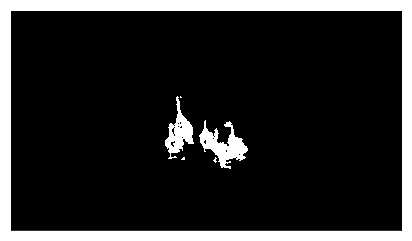

In [90]:
binary_min=im1+im2+im3
imshow(binary_min)

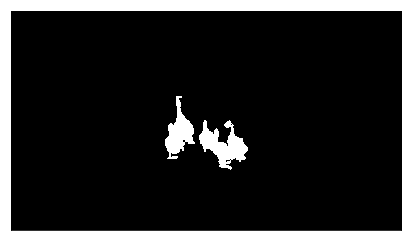

In [87]:
resultado = tratamiento_morfologia(binary_min)
imagenred = tratamiento_bordes(resultado)
imshow(resultado)

### Evaluación de resultados en procentaje por reescala de intensidad

In [88]:
factor_f_evaluation(imagenred,gt_patos) * 100

90.93345617488168